In [104]:
import numpy as np #Handle math objects like vectors and matrixs
import scipy as sp
from scipy.stats import norm # Normal cdf is used
import pandas as pd #Contains data from yahoo
import matplotlib.pyplot as plt # Seeing is believing! --Thrall
from datetime import datetime # Very usefull when you need to operate on date
from datetime import timedelta # Very usefull when you need to operate on date
from yahoo_finance import Share # API from Yahoo to fetch data
%matplotlib inline
float_formatter = lambda x: "%.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
pd.options.display.float_format = '{:20,.3f}'.format

In [126]:
universe = ['SPY','GOOG','AAPL','AMZN','MSFT','IBM','M','MNST','PNC','ROST','COO']

In [127]:
i = datetime.now()
j = i - timedelta(days=252*2)
currentDate = "%s-%s-%s"%(i.year,i.month,i.day)
startDate = "%s-%s-%s"%(j.year,j.month,j.day)

In [128]:
count = 0
for symbol in universe:
    equity = Share(symbol)
    df = pd.DataFrame(equity.get_historical(startDate,currentDate))
    df.index = df.Date
    df.drop('Date',1,inplace = True)
    df.sort_index(inplace = True) # ,ascending = False
    df['Adj_Close'] = pd.to_numeric(df['Adj_Close'])
    label = symbol#+'_logReturn'
    df[label] = np.log(1+df.Adj_Close.diff(1)/df.Adj_Close)
#     df.fillna(0,inplace = True)
    df.dropna(inplace = True)
    
    if count==0:
        M = df[[label]].copy()
    else:
        M = M.join(df[[label]])
    
    count += 1


In [129]:
covMat = np.cov(M.values.T)*252
print(covMat)

[[0.016 0.015 0.017 0.017 0.019 0.015 0.015 0.013 0.021 0.013 0.011]
 [0.015 0.037 0.020 0.032 0.028 0.014 0.009 0.019 0.015 0.016 0.014]
 [0.017 0.020 0.051 0.023 0.023 0.014 0.008 0.012 0.018 0.014 0.015]
 [0.017 0.032 0.023 0.075 0.029 0.014 -0.001 0.031 0.016 0.013 0.014]
 [0.019 0.028 0.023 0.029 0.044 0.018 0.011 0.019 0.020 0.015 0.015]
 [0.015 0.014 0.014 0.014 0.018 0.035 0.016 0.008 0.019 0.010 0.006]
 [0.015 0.009 0.008 -0.001 0.011 0.016 0.153 0.011 0.023 0.032 0.012]
 [0.013 0.019 0.012 0.031 0.019 0.008 0.011 0.072 0.007 0.016 0.011]
 [0.021 0.015 0.018 0.016 0.020 0.019 0.023 0.007 0.049 0.014 0.008]
 [0.013 0.016 0.014 0.013 0.015 0.010 0.032 0.016 0.014 0.051 0.010]
 [0.011 0.014 0.015 0.014 0.015 0.006 0.012 0.011 0.008 0.010 0.049]]


In [138]:
corrMat = np.corrcoef(M.values.T)
print(corrMat)

[[1.000 0.634 0.580 0.503 0.706 0.637 0.295 0.376 0.741 0.461 0.395]
 [0.634 1.000 0.468 0.615 0.697 0.384 0.115 0.365 0.352 0.363 0.324]
 [0.580 0.468 1.000 0.380 0.488 0.333 0.090 0.206 0.358 0.281 0.302]
 [0.503 0.615 0.380 1.000 0.499 0.266 -0.012 0.425 0.268 0.207 0.231]
 [0.706 0.697 0.488 0.499 1.000 0.456 0.134 0.335 0.427 0.316 0.318]
 [0.637 0.384 0.333 0.266 0.456 1.000 0.214 0.169 0.469 0.231 0.143]
 [0.295 0.115 0.090 -0.012 0.134 0.214 1.000 0.106 0.270 0.357 0.136]
 [0.376 0.365 0.206 0.425 0.335 0.169 0.106 1.000 0.119 0.261 0.184]
 [0.741 0.352 0.358 0.268 0.427 0.469 0.270 0.119 1.000 0.271 0.171]
 [0.461 0.363 0.281 0.207 0.316 0.231 0.357 0.261 0.271 1.000 0.200]
 [0.395 0.324 0.302 0.231 0.318 0.143 0.136 0.184 0.171 0.200 1.000]]


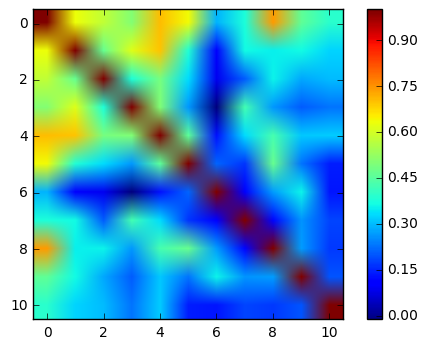

In [141]:
plt.imshow(corrMat)
plt.colorbar()

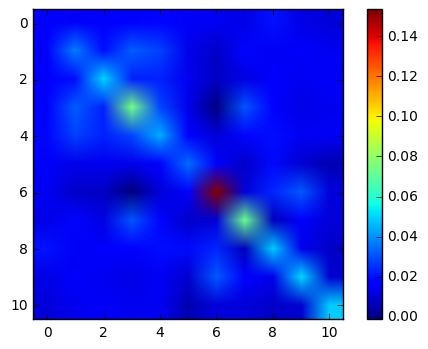

In [134]:
plt.imshow(get_shrunk_(covMat))
plt.colorbar()

In [130]:
sigma = np.linalg.cholesky(covMat)
print(sigma)

[[0.127 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.122 0.148 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.130 0.029 0.181 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.137 0.105 0.013 0.211 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.148 0.068 0.010 0.005 0.132 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.119 -0.005 -0.008 -0.010 0.005 0.143 0.000 0.000 0.000 0.000 0.000]
 [0.115 -0.036 -0.034 -0.061 -0.023 0.007 0.365 0.000 0.000 0.000 0.000]
 [0.101 0.044 -0.011 0.061 0.006 -0.020 0.013 0.236 0.000 0.000 0.000]
 [0.164 -0.034 -0.014 -0.013 -0.015 -0.003 0.005 -0.032 0.139 0.000 0.000]
 [0.104 0.021 0.001 -0.017 -0.013 -0.018 0.052 0.019 -0.021 0.188 0.000]
 [0.087 0.021 0.017 -0.002 0.002 -0.030 0.009 0.003 -0.036 -0.007 0.196]]


In [131]:
np.sum(sigma**2,axis = 1)

array([0.016, 0.037, 0.051, 0.075, 0.044, 0.035, 0.153, 0.072, 0.049,
       0.051, 0.049])